
# Query for pile-up allignments at region "X"

We can query the API services to obtain reads from a given readgroupset such that we are able to make a pileup for any specified region

### Initialize the client

As seen in the "1kg.ipynb" example, we take the following steps to create the client object that will be used to obtain the information we desire and query the serever 

In [1]:
import ga4gh.client as client
c = client.HttpClient("http://1kgenomes.ga4gh.org")

### Make reference to the data from the server

We query the server for the dataset, which is the 1k-genomes dataset.
We access the bases of reference, followed by listingthe reference sets.

In [2]:
dataset = c.searchDatasets().next()
referenceSet = c.searchReferenceSets().next()
references = [r for r in c.searchReferences(referenceSetId = referenceSet.id)]

### ReferenceSet Name (chromosome) & ReadGroupSet Reads
We define our contiguous sequence with a chromosome reference, and then make a reference array for our read group sets of read groups.

In [3]:
contig ={}
for i in references:
    contig[i.name] = str(i.id)

### Functions to obtain ReadGroupSet ID by name. 
We can obtain a set of reads for a given Read-Group. The set of reads is returned in the 'rgs' variable below. 

In [4]:
def GetReadsForName(Name):
    Name = str(Name)
    if type(getReadGroupsByReadGroupSetName(Name)) == str:
        return getReadGroupsByReadGroupSetName(Name)
    else:
        return [i for i in getReadGroupsByReadGroupSetName(Name)]
    
def readGroupSetByName(name):
    result = None
    for rgs in c.searchReadGroupSets(name=name, datasetId=dataset.id):
        return rgs
    return result

def getReadGroupsByReadGroupSetName(readGroupSetName):
    if None == readGroupSetByName(readGroupSetName):
        return "Sorry, bad request for {}".format(readGroupSetName)
    else:
        return readGroupSetByName(readGroupSetName).read_groups

### Function to call multiple ReferenceSets. 
Because some calls such as Variants, Reference Bases, and Reads require this field to return the region that wants to be analyzed. Also note, that it is a required input of this service.  

In [5]:
def chrfunct(Chromo):
    chr1 = filter(lambda x: x.name == str(Chromo), references)[0]
    return chr1

### Cigar-Unit interpreter function.
This function can be expanded in the sense that, INDELS are detected in this function. With more specifications this Pile-Up program with this function can be extended to also detect such variants. Also note that only 4 cigar operations are specified, because they were the only operations specified in the reads. 


In [6]:
def Cigar_Interpreter(Sequence, observe, ReferBase):
    Temp = 0
    BaseCounter = 0
    Variant = ""
    AligSeq = Sequence.aligned_sequence
    InterpArr = list([])
    Iter = 0
    for i in Sequence.alignment.cigar:
        Length = i.operation_length
        if i.Operation.Name(i.operation) == "ALIGNMENT_MATCH":
            InterpArr[len(InterpArr):len(InterpArr)+Length] = AligSeq[Temp:Temp+Length]
            Temp += Length 
            BaseCounter += Length
            
        elif i.Operation.Name(i.operation) == "CLIP_SOFT":
            Temp += Length
            
     
        elif i.Operation.Name(i.operation) == "DELETE":
            int_iter = 0
            for i in range(Length):
                InterpArr[len(InterpArr) : len(InterpArr)+1] = "N"
                BaseCounter += 1
                int_iter += 1
                if BaseCounter == observe:
                    Variant = ReferBase[BaseCounter:BaseCounter+int_iter]
                    return Variant
                
        elif i.Operation.Name(i.operation) == "INSERT":
            for i in range(Length):
                InterpArr[len(InterpArr):len(InterpArr)+1] = AligSeq[Temp : Temp+1]
                Temp += 1
                if (Temp == observe) and (len(InterpArr) >= Temp+Length+1):
                    Variant = "".join(InterpArr[Temp:Temp+Length+1])
                    return Variant
            
        Iter += 1
    if (Temp >= observe) and (len(Sequence.alignment.cigar) == Iter) :
            return InterpArr[observe]
    else: 
        return "N"    
    
    
  

### Variant Call Function
If the pile-up detects that the dominant allele frequency, defers from the reference bases, this function will be call and query the server for that variant.

In [7]:
def find_variants(Start, End, RdGrpSetName, ChromoSm):
    for variantSet in c.searchVariantSets(datasetId=dataset.id):
        if variantSet.name == "phase3-release":
            release = variantSet
    
    for callSet in c.searchCallSets(variantSetId= release.id, name= str(RdGrpSetName)):
        mycallset = callSet
   
    for variant in c.searchVariants(release.id, referenceName=ChromoSm, start=Start, end=End, callSetIds=[mycallset.id]):
        if len(variant.alternate_bases[0]) == 1 and len(variant.reference_bases) == 1:
            print "\nA VARIANT WAS FOUND"
            print "Variant Name: {}, Start: {}, End: {} \nAlternate Bases: {} \nGenotypes: {}".format(str(variant.names[0]), str(variant.start), str(variant.end), str(variant.alternate_bases[0]), str(variant.calls[0].genotype))
            return 
    return False

### Pile up function
This function calculates the pile up's for a given region, that is the position being observed. It takes as input the chromosome reference and the Read-Groups to obtain the needed aligned sequence. 

In [8]:
def pileUp(contig, position, rgset, Chromosm):
    alleles = []
    rgset = GetReadsForName(rgset)
    if type(rgset) != str:
        for i in rgset:
            for sequence in c.searchReads(readGroupIds=[i.id],start = position, end = position+1, referenceId=contig):
                if sequence.alignment != None:
                    start = sequence.alignment.position.position
                    observe = position - sequence.alignment.position.position
                    end = start+len(sequence.aligned_sequence)
                    
                    if observe > 100 or observe < 0:
                        continue
                    
                    if len(sequence.alignment.cigar) > 1:
                        allele = Cigar_Interpreter(sequence, observe,c.listReferenceBases(chrfunct(Chromosm).id, start=start, end= end))      
                    else:
                        allele = sequence.aligned_sequence[observe]
                        
                    alleles.append({"allele": str(allele), "readGroupId":i.id})
        return Calc_Freq(alleles)
    
    else:
        return rgset

### Function to calculate occurrence frequency
The frequency is obtained from the occurrence of alleles in the observed position for all the reads which are mapped in that region. This function returns an array of occurrence alleles as well as their individualized frequency compared to all the reads detected. 

In [9]:
def Calc_Freq(Test):
    tot = len(Test)
    AutCalc = {}
    Arr = []
    for i in range(tot):
        if AutCalc.has_key(Test[i]["allele"]) == False and (Test[i]['allele'] != "N"):
            AutCalc.setdefault(Test[i]["allele"], 1)
            Arr.append(Test[i]['allele'])
        else:
            if Test[i]['allele'] == "N":
                tot -= 1
            else:
                AutCalc[Test[i]["allele"]] = float(AutCalc.get(Test[i]["allele"]) + 1)
    Freq = {}
    print "\n{} Reads where used, to determine pile-up".format(tot) 
    tot = float(tot)
    for i in Arr:
        Freq.setdefault(i,float(AutCalc.get(i)/tot))
    return Freq

### Precursor function
This function prepares the Read-Group set and does the inner calls, it also calls and obtains the reference bases. Note that only if the calls are correct will the function continue to make the calculations and inner calls. 

In [10]:
def Variant_Comp(Position, ReadGroupSetName, Chromosm):
    RdGrp = GetReadsForName(ReadGroupSetName)
    Chrm = contig.get(Chromosm, None) 
    if (Chrm != None) and type(RdGrp) != (str) :
        base = c.listReferenceBases(Chrm, start = Position, end = Position+1)
        var = pileUp(Chrm, Position, ReadGroupSetName, Chromosm)
        return (str(base), var)
    else:
        if RdGrp == None:
            print"Read Group Set '{}' is not in the API".format(ReadGroupSetName)
        else:
            print"Chromosome '{}' is not in the API".format(Chromosm)

### Plotting Function
This function plots, the information obtained by the others. It obtains the reference base and denotes it. It also obtains the frequencies and plots them in a pie chart. 

In [11]:
def plot_vars(Position, RdGrpName, Chromo):
    %matplotlib inline
    import matplotlib.pyplot as plt
    Refer, Freqs = Variant_Comp(int(Position), str(RdGrpName),str(Chromo))
    labels = Freqs.keys()
    sizes = Freqs.values()
    colors = ['yellowgreen', 'gold', 'lightskyblue', 'lightcoral']
    Expl= {}
    Legend = []
    print "Reference Bases:", Refer
    for i in labels:
        if Freqs.get(i) != max(sizes):
            find_variants(int(Position), int(Position)+1, str(RdGrpName), str(Chromo))
            Expl.setdefault(i, .15)
            Legend.append("{}: {} %".format(i, str(Freqs.get(i)*100)[:4]))
        elif i == Refer:
            Expl.setdefault(i,0.8)
            Legend.append("{}: {} %".format(i, str(Freqs.get(i)*100)[:4]))
        else:
            Expl.setdefault(i,0.0)
            Legend.append("{}: {} %".format(i, str(Freqs.get(i)*100)[:4]))
    explode = Expl.values()

    plt.pie(sizes, explode=explode, labels=labels, colors=colors,autopct='%1.1f%%', shadow=True, startangle=0)
    plt.axis('equal')
    plt.legend(['%s' % str(x) for x in (Legend)])
    plt.show()

## Widget Interface Setup
This function calls the previous one, and sets up the interface so that it is an active application. The following one, will beggin the query and pltting process.

In [12]:
def Widget():
    from ipywidgets import widgets
    from ipywidgets import interact
    from IPython.display import display
    
    t0 = widgets.Text(value="Position Exaple:  '120394'", disabled=True)
    text0 = widgets.Text()
    t1 = widgets.Text(value="ReadGroupName Example:  'NA19102'", disabled=True)
    text1 = widgets.Text()
    t2 = widgets.Text(value= "ReferenceSets Example:  '1'", disabled=True)
    text2 = widgets.Text()
    display(t0, text0, t1, text1, t2, text2)
    button = widgets.Button(description="Submit")
    exit = widgets.Button(description="Exit")
    display(button, exit)
    
    
    def exitFunct(c):
        import sys
        sys.exit(["Thank you, you have exited the function"]) 
    
    def Submit(sender):
        Pos, RgSetNm, Chrom = text0.value, text1.value, text2.value
        chr1 = chrfunct(Chrom)
        plot_vars(Pos, RgSetNm, Chrom)
        

    def button_clicked(b):
        print "Position: {}, ReadGrpSet: {}, Chrom: {}".format(text0.value, text1.value, text2.value)
        Submit(b)    

    button.on_click(button_clicked)
    exit.on_click(exitFunct)

Position: 14929, ReadGrpSet: NA21144, Chrom: 1

29 Reads where used, to determine pile-up
Reference Bases: A

A VARIANT WAS FOUND
Variant Name: rs75454623, Start: 14929, End: 14930 
Alternate Bases: G 
Genotypes: [0, 1]


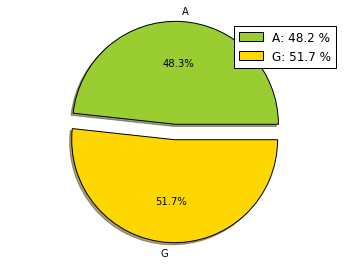

Position: 10100, ReadGrpSet: NA21144, Chrom: 1

308 Reads where used, to determine pile-up
Reference Bases: C


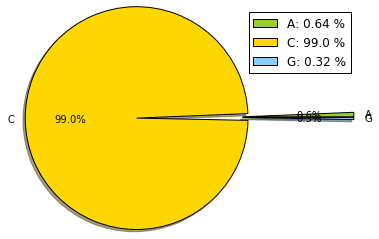

In [13]:
Widget()